In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# spacy for lemmatization
import spacy
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import SnowballStemmer
import string

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # this is mandatory
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [5]:
import pandas as pd

data = pd.read_csv('Bert-629-with-index.csv');
data_text = data[['paragraph']]

documents = data_text
data_text['index'] = data_text.index

In [6]:

len(documents)

1001

In [7]:
documents[:5]

,paragraph,index
0,BERT <REF> is one of a series of pre-trained n...,0
1,Question <REF> Candidate Paragraph BERT : BERT...,1
2,DecAtt + Doc Reader <REF> 31.4 BERT 50.2 BERT...,2
3,"Specifically, we use SQuAD 1.1 <REF>.",3
4,"Specifically, we use SQuAD 1.1 <REF>.",4


## Data Processing

We will perform the following steps:
- Tokenization: Split the text into sentences and the sentences into words. 
- Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Lemmatization — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Stemming — words are reduced to their root form.

Loading gensim and nltk libraries

In [8]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sumairaafzal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lemmatize example

In [10]:
print(WordNetLemmatizer().lemmatize('ate', pos='v'))

eat


### Stemming Example

In [11]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


We write two function to perform lemmatize and stem preprocessing steps on the data set.

In [12]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

#### Select a document to preview after preprocessing.

In [54]:
doc_sample = documents[documents['index'] == 25].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


original document: 
['We', 'build', 'on', 'this', 'latter', 'line', 'of', 'work,', 'focusing', 'on', 'the', 'BERT', 'model', '<REF>,', 'and', 'use', 'a', 'suite', 'of', 'probing', 'tasks', '', 'derived', 'from', 'the', 'traditional', 'NLP', 'pipeline', 'to', 'quantify', 'where', 'specific', 'types', 'of', 'linguistic', 'information', 'are', 'encoded.']


 tokenized and lemmatized document: 
['build', 'line', 'work', 'focus', 'bert', 'model', 'suit', 'probe', 'task', 'deriv', 'tradit', 'pipelin', 'quantifi', 'specif', 'type', 'linguist', 'inform', 'encod']



Preprocess the paragraph text, saving the results as ‘processed_docs’



In [19]:
processed_docs = documents['paragraph'].map(preprocess)

In [20]:

processed_docs[:10]

0    [bert, seri, train, neural, model, fine, tune,...
1    [question, candid, paragraph, bert, bert, base...
2       [decatt, reader, bert, bert, squad, data, set]
3                                      [specif, squad]
4                                      [specif, squad]
5    [recent, year, deep, train, approach, bring, g...
6    [recent, year, transfer, learn, achiev, amaz, ...
7                              [mkdm, implement, bert]
8    [recent, work, pretrain, modul, handcraft, sub...
9    [inspir, superior, transform, text, generat, t...
Name: paragraph, dtype: object

### Bag of words on the dataset

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [21]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [22]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 align
1 base
2 bert
3 fine
4 includ
5 model
6 neural
7 provid
8 result
9 seri
10 squad


Gensim filter_extremes

Filter out tokens that appear in

- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 100000 most frequent tokens.


In [23]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#### Gensim doc2bow
For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.


In [26]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[510]

[(1, 1), (21, 1), (40, 1), (42, 1), (57, 1)]

Preview Bag Of Words for our sample preprocessed document.

In [30]:
bow_doc_510 = bow_corpus[510]

for i in range(len(bow_doc_510)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_510[i][0], 
                                                     dictionary[bow_doc_510[i][0]], 
                                                     bow_doc_510[i][1]))

Word 1 ("bert") appears 1 time.
Word 2 ("fine") appears 1 time.
Word 3 ("includ") appears 1 time.
Word 4 ("model") appears 1 time.
Word 7 ("result") appears 1 time.
Word 9 ("state") appears 1 time.
Word 10 ("task") appears 2 time.
Word 11 ("train") appears 1 time.
Word 12 ("tune") appears 1 time.
Word 21 ("transform") appears 1 time.
Word 24 ("specif") appears 1 time.
Word 27 ("recent") appears 1 time.
Word 39 ("propos") appears 1 time.
Word 40 ("represent") appears 1 time.
Word 42 ("encod") appears 1 time.
Word 53 ("dataset") appears 1 time.
Word 57 ("bidirect") appears 1 time.
Word 109 ("recognit") appears 1 time.
Word 140 ("entiti") appears 1 time.


### TF-IDF


Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [31]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [32]:
corpus_tfidf = tfidf[bow_corpus]

In [33]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.23249396972525127),
 (1, 0.10002269272416411),
 (2, 0.2809793135065915),
 (3, 0.322226785976792),
 (4, 0.08640571053765493),
 (5, 0.2988979655997921),
 (6, 0.4216703619443007),
 (7, 0.3073043522585172),
 (8, 0.43728907362279806),
 (9, 0.2679701946366647),
 (10, 0.1497938656904082),
 (11, 0.15065020896961648),
 (12, 0.27559262012070435)]


### Running LDA using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [79]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=20, 
                                       id2word=dictionary, 
                                       alpha=0.01,
                                       eta=0.9,
                                       passes=2, 
                                       workers=2)

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

For each topic, we will explore the words occuring in that topic and its relative weight.

In [80]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.038*"bert" + 0.035*"represent" + 0.033*"encod" + 0.030*"transform" + 0.022*"languag" + 0.020*"bidirect" + 0.019*"data" + 0.019*"learn" + 0.019*"task" + 0.018*"paper"
Topic: 1 
Words: 0.048*"learn" + 0.034*"model" + 0.033*"data" + 0.019*"languag" + 0.016*"transfer" + 0.016*"effect" + 0.015*"encod" + 0.014*"bert" + 0.014*"differ" + 0.013*"deep"
Topic: 2 
Words: 0.114*"bert" + 0.083*"model" + 0.046*"layer" + 0.035*"base" + 0.024*"larg" + 0.018*"classif" + 0.018*"tune" + 0.017*"train" + 0.017*"pretrain" + 0.017*"follow"
Topic: 3 
Words: 0.079*"model" + 0.068*"bert" + 0.025*"languag" + 0.022*"pretrain" + 0.021*"method" + 0.021*"recent" + 0.019*"encod" + 0.019*"learn" + 0.019*"relat" + 0.018*"represent"
Topic: 4 
Words: 0.061*"transform" + 0.040*"bert" + 0.037*"bidirect" + 0.035*"train" + 0.029*"encod" + 0.025*"task" + 0.024*"model" + 0.022*"attent" + 0.022*"represent" + 0.020*"languag"
Topic: 5 
Words: 0.063*"model" + 0.042*"bert" + 0.040*"task" + 0.037*"state" + 0.023*"l

### Running LDA using TF-IDF

In [81]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,alpha=0.01,
                                           eta=0.9, id2word=dictionary, passes=2, workers=4)

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

In [82]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"embed" + 0.013*"train" + 0.013*"recent" + 0.012*"contextu" + 0.012*"corpus" + 0.012*"architectur" + 0.011*"section" + 0.010*"method" + 0.010*"current" + 0.010*"similar"
Topic: 1 Word: 0.024*"learn" + 0.016*"represent" + 0.016*"word" + 0.015*"recent" + 0.013*"model" + 0.013*"deep" + 0.013*"machin" + 0.013*"text" + 0.012*"task" + 0.011*"year"
Topic: 2 Word: 0.024*"question" + 0.018*"languag" + 0.016*"answer" + 0.016*"natur" + 0.015*"bert" + 0.013*"task" + 0.013*"train" + 0.013*"model" + 0.012*"base" + 0.011*"includ"
Topic: 3 Word: 0.029*"bert" + 0.023*"base" + 0.021*"model" + 0.020*"pretrain" + 0.019*"languag" + 0.015*"approach" + 0.015*"popular" + 0.015*"learn" + 0.015*"transform" + 0.014*"represent"
Topic: 4 Word: 0.039*"layer" + 0.022*"sequenc" + 0.019*"initi" + 0.018*"token" + 0.017*"architectur" + 0.017*"bert" + 0.017*"model" + 0.016*"base" + 0.014*"learn" + 0.014*"paramet"
Topic: 5 Word: 0.027*"sentenc" + 0.021*"answer" + 0.019*"task" + 0.019*"dataset" + 0.018

### Classification of the topics
### Performance evaluation by classifying sample document using LDA Bag of Words model

In [83]:
processed_docs[610]

['experi',
 'demonstr',
 'potenti',
 'bert',
 'standalon',
 'languag',
 'model',
 'paramet',
 'initi',
 'transfer',
 'learn']

In [84]:
for index, score in sorted(lda_model[bow_corpus[610]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9793478846549988	 
Topic: 0.079*"model" + 0.068*"bert" + 0.025*"languag" + 0.022*"pretrain" + 0.021*"method" + 0.021*"recent" + 0.019*"encod" + 0.019*"learn" + 0.019*"relat" + 0.018*"represent"


### Performance evaluation by classifying sample document using LDA TF-IDF model

In [85]:
for index, score in sorted(lda_model_tfidf[bow_corpus[610]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9793478846549988	 
Topic: 0.039*"layer" + 0.022*"sequenc" + 0.019*"initi" + 0.018*"token" + 0.017*"architectur" + 0.017*"bert" + 0.017*"model" + 0.016*"base" + 0.014*"learn" + 0.014*"paramet"


In [86]:
from gensim.models import CoherenceModel
lda_cm=CoherenceModel(model=lda_model_tfidf,corpus=corpus_tfidf,dictionary=dictionary,texts= processed_docs,coherence='c_v')
LDA_cm=lda_cm.get_coherence()
LDA_cm

0.3154031473041557

In [87]:
from gensim.models import CoherenceModel
lda_cm=CoherenceModel(model=lda_model,corpus=bow_corpus,dictionary=dictionary,texts= processed_docs,coherence='c_v')
LDA_cm=lda_cm.get_coherence()
LDA_cm

0.30728184569787437

In [88]:
import pyLDAvis.gensim                             #Play around with the interactive pyLDAvis image
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.038542  0.025399       1        1  14.256128
17     0.026323 -0.017566       2        1  10.928033
14    -0.019807  0.033776       3        1   6.916254
4      0.002756  0.007555       4        1   6.836965
3      0.012802  0.011408       5        1   6.501573
16     0.004878 -0.011699       6        1   5.954264
9      0.006942 -0.000663       7        1   5.759983
5      0.006598 -0.004061       8        1   5.349836
2     -0.002324 -0.013570       9        1   4.497800
7     -0.021020  0.005238      10        1   4.491056
6     -0.003483 -0.014334      11        1   4.263457
19    -0.001993  0.003063      12        1   3.961574
18    -0.006907  0.011391      13        1   3.819785
1     -0.011033 -0.002734      14        1   3.603633
8      0.003178 -0.007083      15        1   3.371451
11    -0.010155 -0.005744      16        1   3.311340
12    -0.006070 -0.007654      17        1   2.539827
13    -0.004440 -0.003497      18        1   2.033285
0     -0.008380 -0.000193      19        1   0.941862
10    -0.006409 -0.009032      20        1   0.661897, topic_info=    Category       Freq         Term      Total  loglift  logprob
72   Default  22.000000        embed  22.000000  30.0000  30.0000
69   Default  31.000000         word  31.000000  29.0000  29.0000
17   Default  24.000000        layer  24.000000  28.0000  28.0000
128  Default  17.000000       method  17.000000  27.0000  27.0000
93   Default  11.000000       corpus  11.000000  26.0000  26.0000
20   Default  16.000000     question  16.000000  25.0000  25.0000
123  Default  16.000000       follow  16.000000  24.0000  24.0000
27   Default  24.000000       recent  24.000000  23.0000  23.0000
102  Default  12.000000        level  12.000000  22.0000  22.0000
144  Default  13.000000       effect  13.000000  21.0000  21.0000
96   Default  11.000000      describ  11.000000  20.0000  20.0000
46   Default  19.000000  architectur  19.000000  19.0000  19.0000
108  Default  12.000000         like  12.000000  18.0000  18.0000
13   Default  17.000000       attent  17.000000  17.0000  17.0000
51   Default  15.000000       answer  15.000000  16.0000  16.0000
10   Default  32.000000         task  32.000000  15.0000  15.0000
50   Default  19.000000        token  19.000000  14.0000  14.0000
66   Default  17.000000         mask  17.000000  13.0000  13.0000
48   Default  34.000000      languag  34.000000  12.0000  12.0000
74   Default  18.000000        natur  18.000000  11.0000  11.0000
75   Default  23.000000      sentenc  23.000000  10.0000  10.0000
88   Default  10.000000         imag  10.000000   9.0000   9.0000
30   Default  25.000000        learn  25.000000   8.0000   8.0000
91   Default  12.000000       machin  12.000000   7.0000   7.0000
126  Default  14.000000       vector  14.000000   6.0000   6.0000
146  Default  13.000000       consid  13.000000   5.0000   5.0000
5    Default  18.000000       neural  18.000000   4.0000   4.0000
3    Default  15.000000       includ  15.000000   3.0000   3.0000
11   Default  34.000000        train  34.000000   2.0000   2.0000
9    Default  20.000000        state  20.000000   1.0000   1.0000
..       ...        ...          ...        ...      ...      ...
67   Topic20   0.174104       object  15.372369   0.5371  -4.5516
127  Topic20   0.151597      develop  13.619586   0.5198  -4.6901
85   Topic20   0.170343      classif  15.684086   0.4952  -4.5735
91   Topic20   0.135138       machin  12.536887   0.4877  -4.8050
28   Topic20   0.120831         year  11.249620   0.4841  -4.9169
14   Topic20   0.126898         head  11.978302   0.4703  -4.8679
114  Topic20   0.121105       number  11.584065   0.4571  -4.9146
157  Topic20   0.112876     convolut  11.201634   0.4203  -4.9850
38   Topic20   0.106534       inspir  10.585246   0.4191  -5.0428
41   Topic20   0.112876       depend  11.240228   0.4168  -4.98

## Latent Semantic Indexing Model


In [100]:
from gensim.models import LsiModel
lsi_model_tfidf = gensim.models.LsiModel(corpus_tfidf, num_topics=20, id2word=dictionary)

In [101]:
lsi_topics = lsi_model_tfidf.print_topics()
for topic in lsi_topics:
    print(topic)

(0, '0.266*"bert" + 0.259*"model" + 0.257*"languag" + 0.245*"train" + 0.228*"represent" + 0.215*"task" + 0.209*"word" + 0.203*"transform" + 0.164*"encod" + 0.161*"base"')
(1, '-0.613*"word" + -0.410*"embed" + -0.267*"contextu" + 0.210*"transform" + 0.181*"base" + -0.165*"emb" + 0.150*"layer" + -0.144*"vector" + -0.137*"represent" + 0.135*"bert"')
(2, '0.367*"transform" + 0.305*"encod" + 0.283*"bidirect" + -0.274*"task" + 0.261*"layer" + -0.204*"languag" + -0.189*"natur" + 0.180*"bert" + 0.166*"represent" + 0.160*"base"')
(3, '-0.372*"bert" + -0.313*"larg" + 0.248*"encod" + 0.237*"transform" + -0.214*"base" + -0.213*"fine" + -0.210*"tune" + -0.205*"train" + 0.186*"bidirect" + 0.166*"network"')
(4, '-0.476*"token" + 0.296*"represent" + -0.278*"layer" + -0.249*"follow" + 0.203*"bidirect" + -0.199*"input" + -0.174*"attent" + 0.170*"languag" + -0.167*"question" + -0.154*"sequenc"')
(5, '0.329*"fine" + 0.329*"tune" + 0.312*"sentenc" + -0.294*"base" + 0.224*"encod" + 0.217*"token" + -0.216*"n

In [102]:
from gensim.models import CoherenceModel
lsi_cm=CoherenceModel(model=lsi_model_tfidf,corpus=corpus_tfidf,dictionary=dictionary,texts= processed_docs,coherence='c_v')
LSI_cm=lsi_cm.get_coherence()
LSI_cm

0.28231982451972676

In [103]:
from gensim.models import CoherenceModel
lsi_cm=CoherenceModel(model=lda_model,corpus=bow_corpus,dictionary=dictionary,texts= processed_docs,coherence='c_v')
LSI_cm=lda_cm.get_coherence()
LSI_cm

0.30728184569787437

In [105]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

hdp = HdpModel(corpus_tfidf,  id2word=dictionary)

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:222: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


In [106]:
hdp_topics = hdp.print_topics()
for topic in hdp_topics:
    print(topic)

(0, '0.033*show + 0.026*classif + 0.024*word + 0.021*network + 0.020*popular + 0.020*supervis + 0.020*depend + 0.020*input + 0.018*predict + 0.017*pretrain')
(1, '0.035*featur + 0.030*bert + 0.023*attent + 0.020*learn + 0.020*includ + 0.019*provid + 0.018*benchmark + 0.018*direct + 0.016*work + 0.016*understand')
(2, '0.034*advanc + 0.032*downstream + 0.029*comprehens + 0.025*recent + 0.023*process + 0.023*best + 0.022*understand + 0.022*emb + 0.021*number + 0.019*token')
(3, '0.034*squad + 0.026*popular + 0.023*architectur + 0.023*better + 0.021*emb + 0.021*self + 0.020*encod + 0.020*neural + 0.020*tune + 0.020*similar')
(4, '0.025*hide + 0.022*work + 0.022*perform + 0.022*input + 0.020*consist + 0.019*entiti + 0.019*captur + 0.019*token + 0.019*baselin + 0.019*addit')
(5, '0.042*base + 0.036*glove + 0.028*embed + 0.028*effect + 0.028*level + 0.024*initi + 0.023*question + 0.022*perform + 0.021*recognit + 0.021*label')
(6, '0.032*number + 0.032*unsupervis + 0.025*section + 0.021*mecha

In [113]:
from gensim.models import CoherenceModel
hdp_cm=CoherenceModel(model=hdp,corpus=corpus_tfidf,dictionary=dictionary,texts= processed_docs,coherence='c_v')
HDP_cm=hdp_cm.get_coherence()
HDP_cm

0.4219428501926666

In [111]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

hdp_BOW = HdpModel(bow_corpus,  id2word=dictionary)

/Users/sumairaafzal/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:222: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


In [112]:
hdp_topics_BOW = hdp_BOW.print_topics()
for topic in hdp_topics_BOW:
    print(topic)

(0, '0.033*layer + 0.028*provid + 0.026*instanc + 0.023*fine + 0.021*tune + 0.019*infer + 0.019*obtain + 0.019*encod + 0.018*generat + 0.018*semant')
(1, '0.035*addit + 0.032*inspir + 0.024*contextu + 0.022*dataset + 0.022*sentiment + 0.021*introduc + 0.021*give + 0.020*sentenc + 0.020*model + 0.019*length')
(2, '0.041*base + 0.027*train + 0.027*entiti + 0.025*document + 0.024*obtain + 0.020*like + 0.019*emb + 0.019*infer + 0.019*context + 0.019*year')
(3, '0.020*squad + 0.020*model + 0.019*train + 0.019*method + 0.019*read + 0.019*experi + 0.018*languag + 0.017*research + 0.017*lstm + 0.016*classif')
(4, '0.033*head + 0.032*differ + 0.023*method + 0.023*represent + 0.021*current + 0.020*vector + 0.019*context + 0.017*transform + 0.017*baselin + 0.015*applic')
(5, '0.033*captur + 0.026*number + 0.024*supervis + 0.023*train + 0.020*effect + 0.019*input + 0.019*model + 0.018*hide + 0.018*vision + 0.018*appli')
(6, '0.041*architectur + 0.033*predict + 0.031*appli + 0.031*downstream + 0.02

In [114]:
from gensim.models import CoherenceModel
hdp_bow_cm=CoherenceModel(model=hdp_BOW,corpus=bow_corpus,dictionary=dictionary,texts= processed_docs,coherence='c_v')
HDP_cm=hdp_bow_cm.get_coherence()
HDP_cm

0.4258492137234549

## Visualizing the Coherence Comparison of the three models

In [115]:
coherence_BOW = {'LDA_cm':0.3072,'LSI_cm':0.3072,'HDP_cm':0.4258}

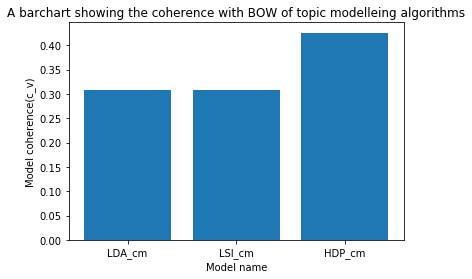

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
coherence_value = list(coherence_BOW.values())
model_name = list(coherence_BOW.keys())
plt.bar(range(len(model_name)),coherence_value,tick_label=model_name)
plt.title('A barchart showing the coherence with BOW of topic modelleing algorithms')
plt.xlabel('Model name')
plt.ylabel('Model coherence(c_v)')
plt.show()

In [123]:
coherence_tfidf = {'LDA_cm':0.3154,'LSI_cm':0.2823,'HDP_cm':0.4219}

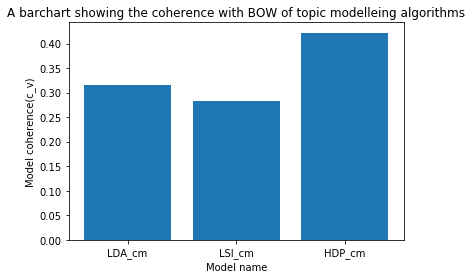

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
coherence_value = list(coherence_tfidf.values())
model_name = list(coherence_tfidf.keys())
plt.bar(range(len(model_name)),coherence_value,tick_label=model_name)
plt.title('A barchart showing the coherence with tf_idf of topic modelleing algorithms')
plt.xlabel('Model name')
plt.ylabel('Model coherence(c_v)')
plt.show()